In [1]:
from transformers import AutoTokenizer, AutoModel, TFAutoModel, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification, BertModel, BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding
import torch.nn.functional as F
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Concatenate, GlobalAveragePooling1D
import torch
from sentence_transformers import SentenceTransformer, util
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from torchsummary import summary
import tensorflow as tf
import datasets
from datasets import Dataset, DatasetDict, load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import softmax
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
from time import time
import gc

In [2]:
class Sample:
    pass

class Factual_info:
    def __init__(self,text):
         self.text = text
         self.sent = [0,0,0]
         self.sent_pred = 0
         self.off = 0
         self.off_pred = 0
         self.hate_peace = 0
         self.peace_pred = 0
         self.hate_gen = 0
         self.gen_pred = 0
         self.hate_hateBERT = 0
         self.hateBERT_pred = 0
         self.sem_emb = 0
    
    def print_info(self):
        print("Text:")
        print(self.text)
        print()
        print("Sentiment")
        print("Negative:",self.sent[0])
        print("Neutral:",self.sent[1])
        print("Positive:",self.sent[2])
        print()
        print("Offense:",self.off)
        print()
        print("Hate of PEACE:",self.hate_peace)
        print()
        print("Hate of the general module:",self.hate_gen)
        print()
        print("Hate of HateBERT:",self.hate_hateBERT)
        
class Metrics:
    def __init__(self):
        self.dist_sent = 0
        self.dist_off = 0
        self.same_sent = 0
        self.distinct_off = 0
        self.off_improvement = 0
        self.sem_sim = 0
    
    def print_metrics(self):
        print("Metrics")
        print("Sentiment distance:",self.dist_sent)
        print("Offense distance:",self.dist_off)
        print()
        print("Same Sentiment:",self.same_sent)
        print("Distinct Offense:",self.distinct_off)
        print("Offense improvement:",self.off_improvement)
        print()
        print("Sentence similarity:",self.sem_sim)
        

# Causal modules

In [3]:
#roBERTa models
sent_MOD = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
aggr_MOD = f"cardiffnlp/twitter-roberta-base-offensive"

#Load tokenizer and models
tokenizer = AutoTokenizer.from_pretrained(sent_MOD)
sent_class_mod = AutoModelForSequenceClassification.from_pretrained(sent_MOD)
aggr_class_mod = AutoModelForSequenceClassification.from_pretrained(aggr_MOD)

sent_class_mod.eval()
aggr_class_mod.eval();

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
def Compute_Caus_Outs(tokenizer,sent_mod,aggr_mod,texts,batch_size):
  # Split texts into batches
  batches = [texts[i:i + batch_size] for i in range(0, len(texts), batch_size)]
  batch_out_1 = []
  batch_out_2 = []
    
  with torch.no_grad():
      for batch in batches:
          encoded_inputs = tokenizer(batch,padding=True,return_tensors='pt')
          # Compute the outputs of the modules as numpy arrays.
          emb_1 = sent_mod(**encoded_inputs)[0]
          scores_1 = []
          for i in range(emb_1.shape[0]):
                scores_1.append(softmax(emb_1[i].detach().numpy()))
          scores_1 = np.array(scores_1)
          batch_out_1.append(scores_1)  

          emb_2 = aggr_mod(**encoded_inputs)[0]
          scores_2 = []
          for i in range(emb_2.shape[0]):
                scores_2.append(softmax(emb_2[i].detach().numpy()))
          scores_2 = np.array(scores_2)
          batch_out_2.append(scores_2)

          encoded_inputs = None
          emb_1 = None
          emb_2 = None
          gc.collect() 
    
  outs_sent = np.concatenate(batch_out_1,axis=0)
  outs_aggr = np.concatenate(batch_out_2,axis=0)  

  return outs_sent,outs_aggr

## Loading the factuals

In [5]:
def get_texts(df):
    np_array = df["text"].to_numpy()
    texts = []
    for i in range(len(np_array)):
        texts.append(np_array[i])
    return texts

In [6]:
df_factuals = pd.read_csv('data/factuals.tsv',sep='\t')
factuals = get_texts(df_factuals)
labels_factuals = df_factuals["label"].to_numpy()

In [7]:
samples = []
for i in range(len(factuals)):
    samples.append(Sample())
    samples[i].factual = Factual_info(factuals[i])

## Loading the sentiment and offense of the factuals

In [8]:
class_fact_sent = np.load('outs/counterfactuals/class_fact_sent.npy')
class_fact_off = np.load('outs/counterfactuals/class_fact_off.npy')
factual_sent = np.load('outs/counterfactuals/factual_sent.npy')
factual_off = np.load('outs/counterfactuals/factual_off.npy')

In [9]:
for i in range(len(samples)):
    samples[i].factual.sent = class_fact_sent[i]
    samples[i].factual.sent_pred = factual_sent[i]
    samples[i].factual.off = class_fact_off[i][1]
    samples[i].factual.off_pred = factual_off[i] 

## Loading the counterfactuals

In [10]:
n_cf = 5
df_cf_off = pd.read_csv('data/cf_off.tsv',sep='\t')
cf_off = get_texts(df_cf_off)

In [11]:
metrics_cf_off = []
i = 0
for j in range(0,len(cf_off),n_cf):
    cf = []
    met = []
    for k in range(n_cf):
        cf.append(Factual_info(cf_off[j+k]))
        met.append(Metrics())
    samples[i].cf_off = cf.copy()
    metrics_cf_off.append(met.copy())
    i+=1

## Getting the counterfactuals output (If it is already saved you can skip this step)

In [14]:
batch_size = 32

cf_pred_sent = []
cf_pred_off = []
t = time()
class_cf_sent,class_cf_off = Compute_Caus_Outs(tokenizer,sent_class_mod,aggr_class_mod,cf_off,batch_size)
print("Elapsed time:",time()-t)
for i in range(len(cf_off)):
        cf_pred_sent.append(class_cf_sent[i].argmax())
        cf_pred_off.append(class_cf_off[i].argmax())    

Elapsed time: 2045.682382106781


In [15]:
np.save('outs/counterfactuals/class_cf_sent.npy',class_cf_sent)
np.save('outs/counterfactuals/class_cf_off.npy',class_cf_off)
np.save('outs/counterfactuals/cf_pred_sent.npy',cf_pred_sent)
np.save('outs/counterfactuals/cf_pred_off.npy',cf_pred_off)

## Loading the counterfactuals output

In [12]:
class_cf_sent = np.load('outs/counterfactuals/class_cf_sent.npy')
class_cf_off = np.load('outs/counterfactuals/class_cf_off.npy')
cf_pred_sent = np.load('outs/counterfactuals/cf_pred_sent.npy')
cf_pred_off = np.load('outs/counterfactuals/cf_pred_off.npy')

In [13]:
i = 0
for j in range(0,len(cf_off),n_cf):
    for k in range(n_cf):
        samples[i].cf_off[k].sent = class_cf_sent[j+k]
        samples[i].cf_off[k].sent_pred = cf_pred_sent[j+k]
        samples[i].cf_off[k].off = class_cf_off[j+k][1]
        samples[i].cf_off[k].off_pred = cf_pred_off[j+k]
    i+=1

# Training texts

In [14]:
def get_texts(df):
    np_array = df["text"].to_numpy()
    texts = []
    for i in range(len(np_array)):
        texts.append(np_array[i])
    return texts

In [15]:
def truncate(texts,max_length):
    for i in range(len(texts)):
      if len(texts[i]) > max_length:
        texts[i] = texts[i][:max_length]
    return texts

## FRENK

In [16]:
df_train = pd.read_csv('data/frenk_train.tsv',sep='\t')
frenk_train = get_texts(df_train)

In [17]:
max_length = 150
frenk_train = truncate(frenk_train,max_length)

## Twi-Red-You dataset

In [18]:
#Twi-Red-You dataset
df_train = pd.read_csv('data/try_train.tsv',sep='\t')
try_train = get_texts(df_train)

In [19]:
max_length = 150
try_train = truncate(try_train,max_length)

# Hate models

## PEACE model

In [20]:
batch_size = 32

In [21]:
#roBERTa models
sent_MOD = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
gen_MOD = f"roberta-base"

#Load tokenizer and models
tokenizer = AutoTokenizer.from_pretrained(sent_MOD)
sent_mod = TFAutoModel.from_pretrained(sent_MOD)
gen_mod = TFAutoModel.from_pretrained(gen_MOD)

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceCl

In [22]:
def Compute_Embeddings(tokenizer,sent_mod,gen_mod,texts,batch_size):
  # Split texts into batches
  batches = [texts[i:i + batch_size] for i in range(0, len(texts), batch_size)]
  batch_out_1 = []
  batch_out_2 = []
  for batch in batches:
      encoded_inputs = tokenizer(batch,padding=True,return_tensors='tf')
      # Compute the outputs of the modules as numpy arrays.
      emb_1 = sent_mod(encoded_inputs)[0]
      pool_1 = GlobalAveragePooling1D()(emb_1).numpy()
      batch_out_1.append(pool_1)

      emb_2 = gen_mod(encoded_inputs)[0]
      pool_2 = GlobalAveragePooling1D()(emb_2).numpy()
      batch_out_2.append(pool_2)
    
      encoded_inputs = None
      emb_1 = None
      emb_2 = None
      gc.collect() 
    
  outs_1 = np.concatenate(batch_out_1,axis=0)
  outs_2 = np.concatenate(batch_out_2,axis=0) 

  return outs_1,outs_2

### Getting the embeddings of the factuals and counterfactuals (If they are already saved you can skip this step)

In [29]:
###Factuals
t = time()
out_sent,out_gen = Compute_Embeddings(tokenizer,sent_mod,gen_mod,factuals,batch_size)
print("Elapsed time:",time()-t)

np.save('outs/counterfactuals/sent_fact_outs.npy',out_sent)
np.save('outs/counterfactuals/gen_fact_outs.npy',out_gen)

Elapsed time: 69.61565518379211


In [30]:
###Counterfactuals
t = time()
out_sent,out_gen = Compute_Embeddings(tokenizer,sent_mod,gen_mod,cf_off,batch_size)
print("Elapsed time:",time()-t)

np.save('outs/counterfactuals/sent_cf_off_outs.npy',out_sent)
np.save('outs/counterfactuals/gen_cf_off_outs.npy',out_gen)

Elapsed time: 351.1544749736786


### Getting the embeddings of the training data (If they are already saved you can skip this step)

In [27]:
### FRENK dataset
t = time()
outs_sent,outs_gen = Compute_Embeddings(tokenizer,sent_mod,gen_mod,frenk_train,batch_size)
print("Elapsed time:",time()-t)

np.save('outs/frenk/sent_train_outs.npy',outs_sent)
np.save('outs/frenk/gen_train_outs.npy',outs_gen)

Elapsed time: 194.65657758712769


In [28]:
### Twi-Red-You set
t = time()
outs_sent,outs_gen = Compute_Embeddings(tokenizer,sent_mod,gen_mod,try_train,batch_size)
print("Elapsed time:",time()-t)

np.save('outs/try/sent_train_outs.npy',outs_sent)
np.save('outs/try/gen_train_outs.npy',outs_gen)

Elapsed time: 183.59531712532043


### Loading the embeddings of the factuals and counterfactuals

In [23]:
###Factuals
sent_fact_outs = np.load('outs/counterfactuals/sent_fact_outs.npy')
gen_fact_outs = np.load('outs/counterfactuals/gen_fact_outs.npy')

In [24]:
###Counterfactuals
sent_cf_off_outs = np.load('outs/counterfactuals/sent_cf_off_outs.npy')
gen_cf_off_outs = np.load('outs/counterfactuals/gen_cf_off_outs.npy')

In [25]:
conc_fact = np.concatenate([sent_fact_outs,gen_fact_outs],axis=1)
conc_cf_off = np.concatenate([sent_cf_off_outs,gen_cf_off_outs],axis=1)

### Load training embeddings

In [26]:
frenk_sent_train = np.load('outs/frenk/sent_train_outs.npy')
frenk_gen_train = np.load('outs/frenk/gen_train_outs.npy')

In [27]:
try_sent_train = np.load('outs/try/sent_train_outs.npy')
try_gen_train = np.load('outs/try/gen_train_outs.npy')

In [28]:
sent_train = np.concatenate([frenk_sent_train,try_sent_train],axis=0)
gen_train = np.concatenate([frenk_gen_train,try_gen_train],axis=0)

In [29]:
conc_train = np.concatenate([sent_train,gen_train],axis=1)

### Load training data labels

In [30]:
#FRENK dataset
df_train = pd.read_csv('data/frenk_train.tsv',sep='\t')
frenk_label_train = df_train["label"].to_numpy()

In [31]:
#Twi-Red-You dataset
df_train = pd.read_csv('data/try_train.tsv',sep='\t')
try_label_train = df_train['label'].to_numpy()

In [32]:
label_train = np.concatenate([frenk_label_train,try_label_train])

### Training and validation splits

In [33]:
conc_train,conc_val,label_train,label_val = train_test_split(conc_train,label_train,test_size=0.1,random_state=42)

In [34]:
c_weights = compute_class_weight('balanced', classes=np.unique(label_train), y=label_train)
c_weights = {0:c_weights[0], 1:c_weights[1]}

### Getting the output of the PEACE model

In [35]:
n_runs = 20

In [36]:
best_f1_val = 0
best_model = None
for i in range(n_runs):
    hate_model = Sequential([
          Flatten(),
          Dense(128, activation='relu'),
          Dense(128, activation='relu'),
          Dense(1, activation='sigmoid')
      ])
    hate_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    hate_model.fit(conc_train, label_train, class_weight=c_weights, epochs=10, batch_size=32)
    
    #Selecting the model with best f1 score in the validation set
    f_hate = np.squeeze(hate_model.predict(conc_val))
    preds = (f_hate > 0.5).astype(int)
    f1_val = metrics.f1_score(preds,label_val,zero_division=1)
    if f1_val > best_f1_val:
        best_f1_val = f1_val
        best_model = hate_model

Epoch 1/10
517/517 [==============================] - 2s 2ms/step - loss: 0.5534 - accuracy: 0.7052
Epoch 2/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5233 - accuracy: 0.7224
Epoch 3/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5080 - accuracy: 0.7319
Epoch 4/10
517/517 [==============================] - 1s 2ms/step - loss: 0.4969 - accuracy: 0.7346
Epoch 5/10
517/517 [==============================] - 1s 2ms/step - loss: 0.4859 - accuracy: 0.7395
Epoch 6/10
517/517 [==============================] - 1s 2ms/step - loss: 0.4762 - accuracy: 0.7461
Epoch 7/10
517/517 [==============================] - 1s 2ms/step - loss: 0.4624 - accuracy: 0.7509
Epoch 8/10
517/517 [==============================] - 1s 2ms/step - loss: 0.4523 - accuracy: 0.7590
Epoch 9/10
517/517 [==============================] - 1s 2ms/step - loss: 0.4366 - accuracy: 0.7681
Epoch 10/10
58/58 [==============================] - 0s 976us/step
Epoch 1/10
517/517 [=============

In [37]:
# Obtaining the hate of the factuals and counterfactuals
f_hate = np.squeeze(best_model.predict(conc_fact))
cf_off_hate = np.squeeze(best_model.predict(conc_cf_off))

478/478 [==============================] - 0s 813us/step


In [38]:
#Classification metrics of the factuals
preds = (f_hate > 0.5).astype(int)
acc_test = metrics.accuracy_score(preds,labels_factuals)
f1_test = metrics.f1_score(preds,labels_factuals,zero_division=1)

print("Accuracy:",acc_test)
print("F1 score:",f1_test)

Accuracy: 0.7294733398756952
F1 score: 0.6612044244162228


In [39]:
i = 0
for j in range(0,len(cf_off),n_cf):
    samples[i].factual.hate_peace = f_hate[i]
    samples[i].factual.peace_pred = 1 if f_hate[i] > 0.5 else 0
    for k in range(n_cf):
        samples[i].cf_off[k].hate_peace = cf_off_hate[j+k]
        samples[i].cf_off[k].peace_pred = 1 if cf_off_hate[j+k] > 0.5 else 0
    i+=1

## HateBERT

In [49]:
model_dir = "GroNLP/hateBERT"
HateBERT = BertModel.from_pretrained(
    model_dir
)
HateBERT.eval()
HateBERT_tok = BertTokenizer.from_pretrained(model_dir)

In [50]:
def Comp_Embed_HateBERT(tokenizer,mod,texts,batch_size):
  # Split texts into batches
  batches = [texts[i:i + batch_size] for i in range(0, len(texts), batch_size)]
  batch_out = []

  with torch.no_grad():
      for batch in batches:
          encoded_inputs = tokenizer(batch,padding=True,return_tensors='pt')
          # Compute the output of the module as a numpy array.

          emb = mod(**encoded_inputs)[0]
          tf_emb = tf.convert_to_tensor(emb.numpy())  
          pool = GlobalAveragePooling1D()(tf_emb).numpy()
          batch_out.append(pool)

          encoded_inputs = None
          tf_emb = None
          gc.collect() 
    
  outs = np.concatenate(batch_out,axis=0)
  return outs

### Getting the embeddings of the factuals and counterfactuals (If they are already saved you can skip this step)

In [53]:
#Factuals
t = time()
fact_HateBERT = Comp_Embed_HateBERT(HateBERT_tok,HateBERT,factuals,batch_size)
print("Elapsed time:",time()-t)

np.save('outs/counterfactuals/fact_HateBERT.npy',fact_HateBERT)

Elapsed time: 193.25071811676025


In [54]:
#Counterfactuals
t = time()
cf_off_HateBERT = Comp_Embed_HateBERT(HateBERT_tok,HateBERT,cf_off,batch_size)
print("Elapsed time:",time()-t)

np.save('outs/counterfactuals/cf_off_HateBERT.npy',cf_off_HateBERT)

Elapsed time: 1187.0695307254791


### Getting the embeddings of the training data (If they are already saved you can skip this step)

In [ ]:
#FRENK
t = time()
outs_train = Comp_Embed_HateBERT(HateBERT_tok,HateBERT,frenk_train,batch_size)
print("Elapsed time:",time()-t)

np.save('outs/frenk/HateBERT_train_emb.npy',outs_train)

In [48]:
#Twi-Red-You
t = time()
outs_train = Comp_Embed_HateBERT(HateBERT_tok,HateBERT,try_train,batch_size)
print("Elapsed time:",time()-t)

np.save('outs/try/HateBERT_train_emb.npy',outs_train)

Elapsed time: 502.1079571247101


### Loading the embeddings of the factuals and counterfactuals

In [51]:
fact_HateBERT = np.load('outs/counterfactuals/fact_HateBERT.npy')
cf_off_HateBERT = np.load('outs/counterfactuals/cf_off_HateBERT.npy')

### Loading the embeddings of the training data

In [52]:
frenk_train_emb = np.load('outs/frenk/HateBERT_train_emb.npy')
try_train_emb = np.load('outs/try/HateBERT_train_emb.npy')
train_emb = np.concatenate([frenk_train_emb,try_train_emb],axis=0)

In [53]:
#Training-Validation split
train_emb,val_emb = train_test_split(train_emb,test_size=0.1,random_state=42)

### Getting the output of the HateBERT model

In [54]:
best_f1_val = 0
best_model = None
for i in range(n_runs):
    classifier_HateBERT = Sequential([
          Flatten(),
          Dense(128, activation='relu'),
          Dense(128, activation='relu'),
          Dense(1, activation='sigmoid')
      ])
    classifier_HateBERT.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    classifier_HateBERT.fit(train_emb, label_train, class_weight=c_weights, epochs=10, batch_size=32)
    
    #Selecting the model with best f1 score in the validation set
    f_hate = np.squeeze(classifier_HateBERT.predict(val_emb))
    preds = (f_hate > 0.5).astype(int)
    f1_val = metrics.f1_score(preds,label_val,zero_division=1)
    if f1_val > best_f1_val:
        best_f1_val = f1_val
        best_model = classifier_HateBERT

Epoch 1/10
517/517 [==============================] - 3s 5ms/step - loss: 0.5756 - accuracy: 0.6900
Epoch 2/10
517/517 [==============================] - 2s 4ms/step - loss: 0.5375 - accuracy: 0.7030
Epoch 3/10
517/517 [==============================] - 2s 3ms/step - loss: 0.5219 - accuracy: 0.7136
Epoch 4/10
517/517 [==============================] - 2s 3ms/step - loss: 0.5075 - accuracy: 0.7253
Epoch 5/10
517/517 [==============================] - 2s 3ms/step - loss: 0.4942 - accuracy: 0.7383
Epoch 6/10
517/517 [==============================] - 2s 3ms/step - loss: 0.4761 - accuracy: 0.7458
Epoch 7/10
517/517 [==============================] - 2s 3ms/step - loss: 0.4605 - accuracy: 0.7579
Epoch 8/10
517/517 [==============================] - 2s 3ms/step - loss: 0.4427 - accuracy: 0.7665
Epoch 9/10
517/517 [==============================] - 2s 3ms/step - loss: 0.4186 - accuracy: 0.7813
Epoch 10/10
58/58 [==============================] - 0s 3ms/step
Epoch 1/10
517/517 [===============

In [55]:
# Obtaining the hate of the factuals and counterfactuals
f_hate = np.squeeze(best_model.predict(fact_HateBERT))
cf_off_hate = np.squeeze(best_model.predict(cf_off_HateBERT))

478/478 [==============================] - 1s 2ms/step


In [56]:
#Classification metrics of the factuals
preds = (f_hate > 0.5).astype(int)
acc_test = metrics.accuracy_score(preds,labels_factuals)
f1_test = metrics.f1_score(preds,labels_factuals,zero_division=1)

print("Accuracy:",acc_test)
print("F1 score:",f1_test)

Accuracy: 0.7262021589793916
F1 score: 0.6294820717131474


In [57]:
i = 0
for j in range(0,len(cf_off),n_cf):
    samples[i].factual.hate_hateBERT = f_hate[i]
    samples[i].factual.hateBERT_pred = 1 if f_hate[i] > 0.5 else 0
    for k in range(n_cf):
        samples[i].cf_off[k].hate_hateBERT = cf_off_hate[j+k]
        samples[i].cf_off[k].hateBERT_pred = 1 if cf_off_hate[j+k] > 0.5 else 0
    i+=1

## Twitter Roberta Hate

In [58]:
model_dir = "cardiffnlp/twitter-roberta-base-hate-latest"
TwiRobHate = AutoModelForSequenceClassification.from_pretrained(
    model_dir
)
TwiRobHate.eval()
TwiRobHate_tok = AutoTokenizer.from_pretrained(model_dir)

In [59]:
def Comp_Class_TwiRobHate(tokenizer,mod,texts,batch_size):
  # Split texts into batches
  batches = [texts[i:i + batch_size] for i in range(0, len(texts), batch_size)]
  batch_out = []

  with torch.no_grad():
      for batch in batches:
          encoded_inputs = tokenizer(batch,padding=True,return_tensors='pt')
          # Compute the output of the module as a numpy array.

          output = mod(**encoded_inputs)
          probs = F.softmax(output.logits, dim=1)
          probs = probs.detach().cpu().numpy()#[0]
            
          prob_hate = []
          for j in range(len(batch)):
            batch_out.append(probs[j][1])

          encoded_inputs = None
          tf_emb = None
          gc.collect() 
    
  return np.array(batch_out)

### Computing the hate (If it's already saved you can skip this step)

In [62]:
twihate_fact_non_ft = Comp_Class_TwiRobHate(TwiRobHate_tok,TwiRobHate,["Trump is a fucking idiot","I love you"],batch_size)

In [64]:
t = time()
twihate_fact_non_ft = Comp_Class_TwiRobHate(TwiRobHate_tok,TwiRobHate,factuals,batch_size)
print("Elapsed time:",time()-t)

np.save('outs/counterfactuals/twihate_fact_non_ft.npy',twihate_fact_non_ft)

Elapsed time: 186.49867725372314


In [65]:
t = time()
twihate_cf_off_non_ft = Comp_Class_TwiRobHate(TwiRobHate_tok,TwiRobHate,cf_off,batch_size)
print("Elapsed time:",time()-t)

np.save('outs/counterfactuals/twihate_cf_off_non_ft.npy',twihate_cf_off_non_ft)

Elapsed time: 1119.709843635559


### Loading the hate

In [60]:
twihate_fact_non_ft = np.load('outs/counterfactuals/twihate_fact_non_ft.npy')
twihate_cf_off_non_ft = np.load('outs/counterfactuals/twihate_cf_off_non_ft.npy')

In [61]:
preds = (twihate_fact_non_ft > 0.5).astype(int)
acc_test = metrics.accuracy_score(preds,labels_factuals)
f1_test = metrics.f1_score(preds,labels_factuals,zero_division=1)

print("Accuracy:",acc_test)
print("F1 score:",f1_test)

Accuracy: 0.7271835132482827
F1 score: 0.5757884028484231


In [62]:
i = 0
for j in range(0,len(cf_off),n_cf):
    samples[i].factual.hate_twihate_non_ft = twihate_fact_non_ft[i]
    samples[i].factual.twihate_non_ft_pred = 1 if twihate_fact_non_ft[i] > 0.5 else 0
    for k in range(n_cf):
        samples[i].cf_off[k].hate_twihate_non_ft = twihate_cf_off_non_ft[j+k]
        samples[i].cf_off[k].twihate_non_ft_pred = 1 if twihate_cf_off_non_ft[j+k] > 0.5 else 0
    i+=1

## Twitter Roberta Hate with our classifier

In [63]:
model_dir = "cardiffnlp/twitter-roberta-base-hate-latest"
TwiRobHate = AutoModel.from_pretrained(
    model_dir
)
TwiRobHate.eval()
TwiRobHate_tok = AutoTokenizer.from_pretrained(model_dir)

Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate-latest and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
def Comp_Embed_TwiRobHate(tokenizer,mod,texts,batch_size):
  # Split texts into batches
  batches = [texts[i:i + batch_size] for i in range(0, len(texts), batch_size)]
  batch_out = []

  with torch.no_grad():
      for batch in batches:
          encoded_inputs = tokenizer(batch,padding=True,return_tensors='pt')
          # Compute the output of the module as a numpy array.

          emb = mod(**encoded_inputs)[0]
          tf_emb = tf.convert_to_tensor(emb.numpy())  
          pool = GlobalAveragePooling1D()(tf_emb).numpy()
          batch_out.append(pool)

          encoded_inputs = None
          tf_emb = None
          gc.collect() 
    
  outs = np.concatenate(batch_out,axis=0)
  return outs

### Getting the embeddings of the factuals and counterfactuals (If they are already saved you can skip this step)

In [71]:
#Factuals
t = time()
fact_HateBERT = Comp_Embed_TwiRobHate(TwiRobHate_tok,TwiRobHate,factuals,batch_size)
print("Elapsed time:",time()-t)

np.save('outs/counterfactuals/twihate_fact_ft.npy',fact_HateBERT)

Elapsed time: 181.1837875843048


In [72]:
#Counterfactuals
t = time()
cf_off_HateBERT = Comp_Embed_TwiRobHate(TwiRobHate_tok,TwiRobHate,cf_off,batch_size)
print("Elapsed time:",time()-t)

np.save('outs/counterfactuals/twihate_cf_off_ft.npy',cf_off_HateBERT)

Elapsed time: 1104.070522069931


### Getting the embeddings of the training data (If they are already saved you can skip this step)

In [54]:
#FRENK
t = time()
outs_train = Comp_Embed_TwiRobHate(TwiRobHate_tok,TwiRobHate,frenk_train,batch_size)
print("Elapsed time:",time()-t)

np.save('outs/frenk/TwiHate_train_emb.npy',outs_train)

Elapsed time: 598.2584960460663


In [55]:
#Twi-Red-You
t = time()
outs_train = Comp_Embed_TwiRobHate(TwiRobHate_tok,TwiRobHate,try_train,batch_size)
print("Elapsed time:",time()-t)

np.save('outs/try/TwiHate_train_emb.npy',outs_train)

Elapsed time: 544.6722905635834


### Loading the embeddings of the factuals and counterfactuals

In [65]:
fact_TwiRobHate = np.load('outs/counterfactuals/twihate_fact_ft.npy')
cf_off_TwiRobHate = np.load('outs/counterfactuals/twihate_cf_off_ft.npy')

### Loading the embeddings of the training data

In [66]:
frenk_train_emb = np.load('outs/frenk/TwiHate_train_emb.npy')
try_train_emb = np.load('outs/try/TwiHate_train_emb.npy')
train_emb = np.concatenate([frenk_train_emb,try_train_emb],axis=0)

In [67]:
#Training-Validation splits
train_emb,val_emb = train_test_split(train_emb,test_size=0.1,random_state=42)

### Getting the output of the Twitter Roberta Hate model

In [68]:
best_f1_val = 0
best_model = None
for i in range(n_runs):
    classifier_TwiRobHate = Sequential([
          Flatten(),
          Dense(128, activation='relu'),
          Dense(128, activation='relu'),
          Dense(1, activation='sigmoid')
      ])
    classifier_TwiRobHate.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    classifier_TwiRobHate.fit(train_emb, label_train, class_weight=c_weights, epochs=10, batch_size=32)
    
    #Selecting the model with best f1 score in the validation set
    f_hate = np.squeeze(classifier_TwiRobHate.predict(val_emb))
    preds = (f_hate > 0.5).astype(int)
    f1_val = metrics.f1_score(preds,label_val,zero_division=1)
    if f1_val > best_f1_val:
        best_f1_val = f1_val
        best_model = classifier_TwiRobHate

Epoch 1/10
517/517 [==============================] - 3s 3ms/step - loss: 0.5541 - accuracy: 0.7143
Epoch 2/10
517/517 [==============================] - 2s 3ms/step - loss: 0.5241 - accuracy: 0.7328
Epoch 3/10
517/517 [==============================] - 1s 3ms/step - loss: 0.5121 - accuracy: 0.7370
Epoch 4/10
517/517 [==============================] - 2s 3ms/step - loss: 0.5044 - accuracy: 0.7451
Epoch 5/10
517/517 [==============================] - 2s 3ms/step - loss: 0.4919 - accuracy: 0.7540
Epoch 6/10
517/517 [==============================] - 2s 3ms/step - loss: 0.4826 - accuracy: 0.7618
Epoch 7/10
517/517 [==============================] - 2s 4ms/step - loss: 0.4730 - accuracy: 0.7653
Epoch 8/10
517/517 [==============================] - 2s 5ms/step - loss: 0.4621 - accuracy: 0.7721
Epoch 9/10
517/517 [==============================] - 2s 4ms/step - loss: 0.4487 - accuracy: 0.7836
Epoch 10/10
58/58 [==============================] - 0s 2ms/step
Epoch 1/10
517/517 [===============

In [69]:
# Obtaining the hate of the factuals and counterfactuals
f_hate = np.squeeze(best_model.predict(fact_TwiRobHate))
cf_off_hate = np.squeeze(best_model.predict(cf_off_TwiRobHate))

478/478 [==============================] - 1s 1ms/step


In [70]:
#Classification metrics of the factuals
preds = (f_hate > 0.5).astype(int)
acc_test = metrics.accuracy_score(preds,labels_factuals)
f1_test = metrics.f1_score(preds,labels_factuals,zero_division=1)

print("Accuracy:",acc_test)
print("F1 score:",f1_test)

Accuracy: 0.7455021262675826
F1 score: 0.6511210762331839


In [71]:
i = 0
for j in range(0,len(cf_off),n_cf):
    samples[i].factual.hate_twihate_ft = f_hate[i]
    samples[i].factual.twihate_ft_pred = 1 if f_hate[i] > 0.5 else 0
    for k in range(n_cf):
        samples[i].cf_off[k].hate_twihate_ft = cf_off_hate[j+k]
        samples[i].cf_off[k].twihate_ft_pred = 1 if cf_off_hate[j+k] > 0.5 else 0
    i+=1

# Semantic embeddings

In [72]:
sem_trans = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

## Factuals

In [73]:
sem_emb = sem_trans.encode(factuals)
for i in range(len(samples)):
    samples[i].factual.sem_emb = sem_emb[i]

## Offense counterfactuals

In [74]:
sem_emb = sem_trans.encode(cf_off)
i = 0
for j in range(0,len(cf_off),n_cf):
    for k in range(n_cf):
        samples[i].cf_off[k].sem_emb = sem_emb[j+k]
    i+=1

# Evaluation

## Factual vs. Counterfactual metrics

In [75]:
def cf_off_dist_sent(sample,k):
    #Euclidean distance considering the 3 sentiments
    return np.linalg.norm(sample.factual.sent - sample.cf_off[k].sent)

In [76]:
def cf_off_dist_off(sample,k,factual_off):
    if factual_off:
        dist = sample.factual.off - sample.cf_off[k].off 
    else:
        dist = sample.cf_off[k].off - sample.factual.off
    return dist

In [77]:
def cf_off_same_sent(sample,k):
    result = 1 if sample.factual.sent_pred == sample.cf_off[k].sent_pred else 0
    return result 

In [78]:
def cf_off_distinct_off(sample,k,factual_off):
    if factual_off:
        result = 1 if sample.cf_off[k].off_pred==0 else 0 
    else:
        result = 1 if sample.cf_off[k].off_pred==1 else 0
    return result

In [79]:
def cf_off_off_improvement(sample,k,factual_off):
    if factual_off:
        result = 1 if sample.factual.off > sample.cf_off[k].off else 0
    else:
        result = 1 if sample.cf_off[k].off > sample.factual.off else 0
    return result

In [80]:
def sem_similarity(emb1,emb2):
    cos_sim = cosine_similarity([emb1],[emb2])[0][0]
    return cos_sim

In [81]:
#Calculate metrics
for i in range(len(samples)):
    for k in range(n_cf):
        metrics_cf_off[i][k].dist_sent = cf_off_dist_sent(samples[i],k)
        metrics_cf_off[i][k].dist_off = cf_off_dist_off(samples[i],k,factual_off[i])
        metrics_cf_off[i][k].same_sent = cf_off_same_sent(samples[i],k)
        metrics_cf_off[i][k].distinct_off = cf_off_distinct_off(samples[i],k,factual_off[i])
        metrics_cf_off[i][k].off_improvement = cf_off_off_improvement(samples[i],k,factual_off[i])
        metrics_cf_off[i][k].sem_sim = sem_similarity(samples[i].factual.sem_emb,samples[i].cf_off[k].sem_emb)

In [82]:
dists_off = []
dists_sent = []
same_sents = []
distinct_offs = []
off_imprs = []
sem_sims = []
for i in range(len(samples)):
    for k in range(n_cf):
        dists_off.append(metrics_cf_off[i][k].dist_off)
        dists_sent.append(metrics_cf_off[i][k].dist_sent)
        same_sents.append(metrics_cf_off[i][k].same_sent)
        distinct_offs.append(metrics_cf_off[i][k].distinct_off)
        off_imprs.append(metrics_cf_off[i][k].off_improvement)
        sem_sims.append(metrics_cf_off[i][k].sem_sim)

In [83]:
print("Average of offense distances:",np.mean(dists_off))
print("Average of sentiment distances:",np.mean(dists_sent))
print("Accuracy of same sentiment:",np.sum(same_sents)/len(cf_off))
print("Accuracy of distinct offense:",np.sum(distinct_offs)/len(cf_off))
print("Accuracy of offense improvement:",np.sum(off_imprs)/len(cf_off))
print("Average of semantic similarities:",np.mean(sem_sims))

Average of offense distances: 0.39390346
Average of sentiment distances: 0.4441693
Accuracy of same sentiment: 0.6066732090284592
Accuracy of distinct offense: 0.7125286228328427
Accuracy of offense improvement: 0.9432122996401701
Average of semantic similarities: 0.67759293


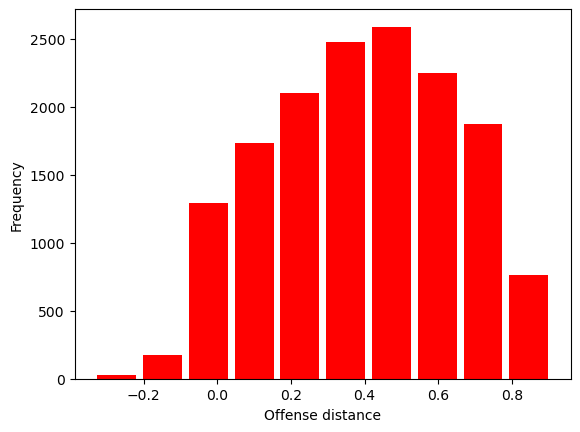

In [84]:
#Histogram of offense distances
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(x=dists_off, color='red',rwidth=0.85)
ax.set_xlabel('Offense distance')
ax.set_ylabel('Frequency')
plt.show()

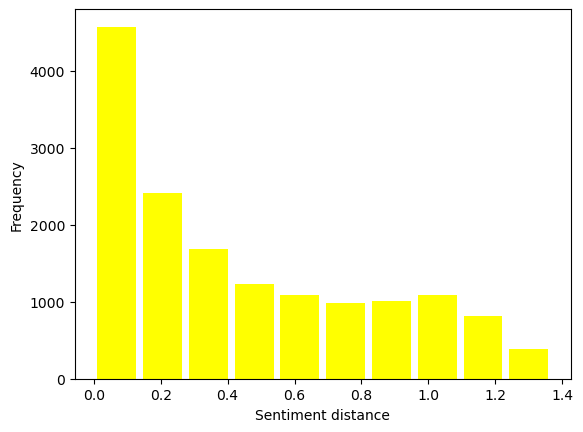

In [85]:
#Histogram of sentiment distances
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(x=dists_sent, color='yellow',rwidth=0.85)
ax.set_xlabel('Sentiment distance')
ax.set_ylabel('Frequency')
plt.show()

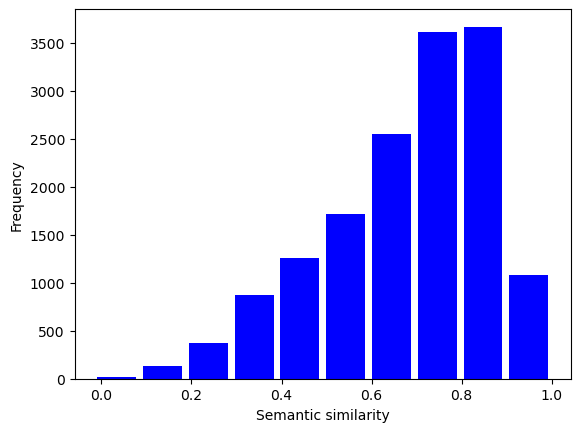

In [86]:
#Histogram of the semantic similarities
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(x=sem_sims, color='blue',rwidth=0.85)
ax.set_xlabel('Semantic similarity')
ax.set_ylabel('Frequency')
plt.show()

## ITE PEACE

In [42]:
ITE_peace = []
for i in range(len(samples)):
    if factual_off[i]:
        for k in range(n_cf):
            ITE_peace.append(samples[i].factual.hate_peace - samples[i].cf_off[k].hate_peace)
    else:
        for k in range(n_cf):
            ITE_peace.append(samples[i].cf_off[k].hate_peace - samples[i].factual.hate_peace)

np.save('outs/counterfactuals/ITE_peace.npy',np.array(ITE_peace))

In [43]:
ITE_peace = np.load('outs/counterfactuals/ITE_peace.npy')

ATE: 0.29957846


<Axes: >

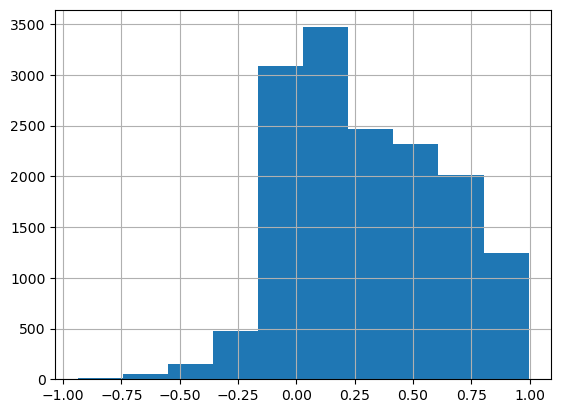

In [44]:
print("ATE:",np.mean(ITE_peace))
pd.Series(ITE_peace).hist()

## ITE hateBERT


In [121]:
ITE_hatebert = []
for i in range(len(samples)):
    if factual_off[i]:
        for k in range(n_cf):
            ITE_hatebert.append(samples[i].factual.hate_hateBERT - samples[i].cf_off[k].hate_hateBERT)
    else:
        for k in range(n_cf):
            ITE_hatebert.append(samples[i].cf_off[k].hate_hateBERT - samples[i].factual.hate_hateBERT)
np.save('outs/counterfactuals/ITE_hatebert.npy',np.array(ITE_hatebert))

ATE: 0.2894892


<Axes: >

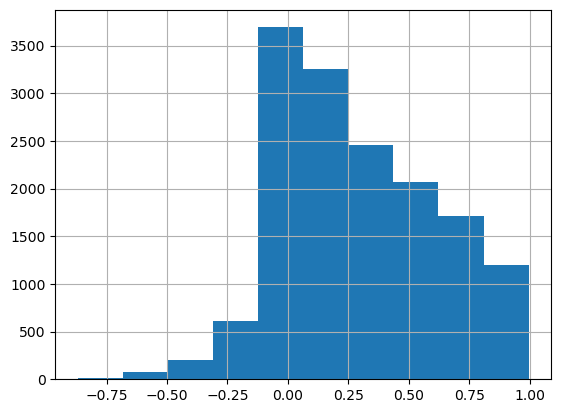

In [122]:
print("ATE:",np.mean(ITE_hatebert))
pd.Series(ITE_hatebert).hist()

## ITE Twitter Roberta Hate

In [125]:
ITE = []
i = 0
for j in range(0,len(cf_off),n_cf):
    if factual_off[i]:
        for k in range(n_cf):
            ITE.append(samples[i].factual.hate_twihate_non_ft - samples[i].cf_off[k].hate_twihate_non_ft)
    else:
        for k in range(n_cf):
            ITE.append(samples[i].cf_off[k].hate_twihate_non_ft - samples[i].factual.hate_twihate_non_ft)
    i+=1
np.save('outs/counterfactuals/ITE_roberta_hate.npy',np.array(ITE))

ATE: 0.3017168


<Axes: >

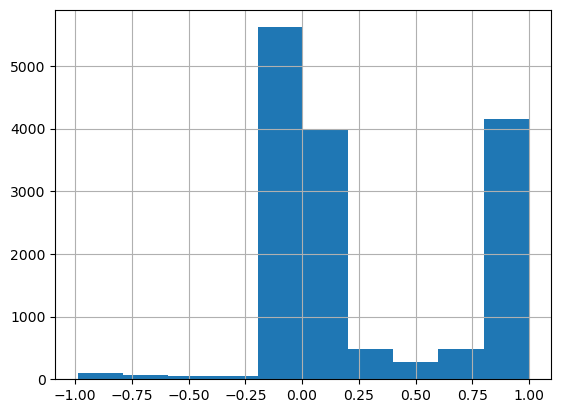

In [126]:
print("ATE:",np.mean(ITE))
pd.Series(ITE).hist()

## ITE Twitter Roberta Hate with our classifier

In [127]:
ITE = []
for i in range(len(samples)):
    if factual_off[i]:
        for k in range(n_cf):
            ITE.append(samples[i].factual.hate_twihate_ft - samples[i].cf_off[k].hate_twihate_ft)
    else:
        for k in range(n_cf):
            ITE.append(samples[i].cf_off[k].hate_twihate_ft - samples[i].factual.hate_twihate_ft)
np.save('outs/counterfactuals/ITE_roberta_hate_clf.npy',np.array(ITE))

ATE: 0.27900615


<Axes: >

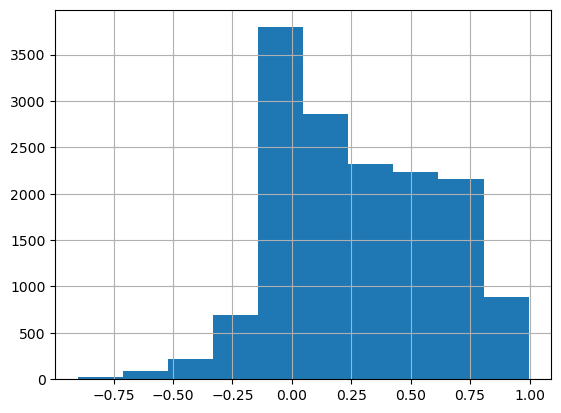

In [128]:
print("ATE:",np.mean(ITE))
pd.Series(ITE).hist()